In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
/bin/bash: cmake: command not found
make: *** No rule to make target 'install'.  Stop.


In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
from commons import linear_regression

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/home/roni/Documents/metnum/metnum-tp3/notebooks
Python 3.8.5


In [3]:
df = pd.read_csv('../data/train.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          240000 non-null  int64  
 1   titulo                      234613 non-null  object 
 2   descripcion                 238381 non-null  object 
 3   tipodepropiedad             239954 non-null  object 
 4   direccion                   186928 non-null  object 
 5   ciudad                      239628 non-null  object 
 6   provincia                   239845 non-null  object 
 7   antiguedad                  196445 non-null  float64
 8   habitaciones                217529 non-null  float64
 9   garages                     202235 non-null  float64
 10  banos                       213779 non-null  float64
 11  metroscubiertos             222600 non-null  float64
 12  metrostotales               188533 non-null  float64
 13  idzona        

### Variables customs
- precioxmetro: representa la relacion entre el precio y los metros totales (esta variable no tiene sentido cuando voy a predecir el precio). Se define como $\frac{precio}{metrostotales}$
- itipodepropiedad: asignacion de identificacion numerica unica arbitraria al tipo de propiedad

In [5]:
df["precioxmetro"] = df["precio"] / df["metrostotales"]

tipos_propiedades = df["tipodepropiedad"].unique()
df["itipodepropiedad"] = df["tipodepropiedad"].map(lambda x: list(tipos_propiedades).index(x))


df["amenities"] = np.where((df["gimnasio"] == 1) | (df["usosmultiples"] == 1) | (df["piscina"] == 1), 1 ,0)

### Prediccion de precio x metro
¿Se puede predecir el precio por metro segun la ubicacion (lat y lng)?

- Dataset: Solo vamos a incluir aquellos datos que contengan metroscubiertos y habitaciones. 
- Input: `lat`,`lng`
- Output: `precioxmetro`

In [6]:
df_prueba = df[np.where((df["lng"] < -98.61) & (df["lng"] > -99.50) & (df["lat"] < 19.67) & (df["lat"] > 19.2), True ,False)]

z_scores = np.abs((df_prueba.precioxmetro - df_prueba.precioxmetro.mean())/df_prueba.precioxmetro.std(ddof=0))
filtered_entries = (z_scores < 3)
df_prueba = df_prueba[filtered_entries]

In [16]:
#https://www.openstreetmap.org/#map=11/19.4258/-99.0878
img_city = plt.imread("map_mex_city.png")

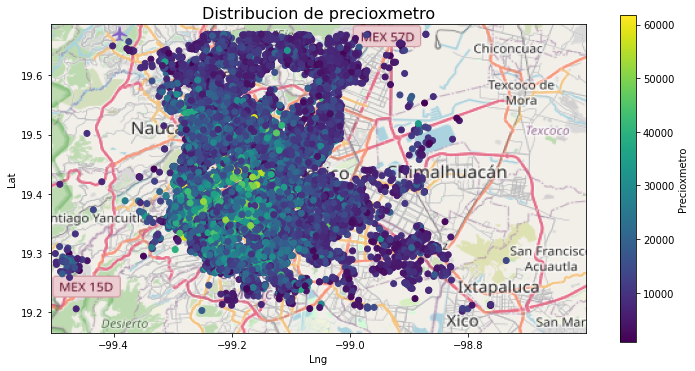

In [8]:
lng = df_prueba['lng'].values
lat = df_prueba['lat'].values
c = df_prueba['precioxmetro'].values

plt.figure(figsize=(12,6))
plt.imshow(img_city, extent=[-99.5066,-98.6002,19.1646,19.6866])
plt.scatter(lng,lat,c=c)
plt.savefig("mapprecios")
plt.title("Distribucion de precioxmetro", fontsize=16)
plt.ylabel("Lat")
plt.xlabel("Lng")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Precioxmetro')
plt.savefig("precioxmetro/dist_precioxmetro_city")
plt.show()

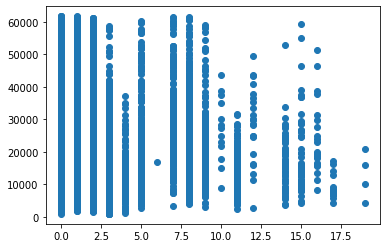

In [8]:
plt.scatter(df_prueba.itipodepropiedad,df_prueba.precioxmetro)
plt.show()

In [9]:
res_prueba,rmse_prueba,rmsle_prueba = linear_regression(df_prueba,["lat","lng"], "precioxmetro", n_splits=4, shuffle=True) 

In [10]:
from sklearn.metrics import r2_score
r2_prueba = 0
for r in res_prueba:
    expec = r["expect"]
    pred = r["pred"]
    r2_prueba+=r2_score(expec,pred)
r2_prueba = np.mean(r2_prueba)

In [11]:
rmse_prueba,rmsle_prueba,r2_prueba,df_prueba.precioxmetro.std(),rmse_prueba/df_prueba.precioxmetro.std()

(11547.674194674888,
 0.626523149575492,
 0.38161367720060224,
 11095.179471831883,
 1.040783001662279)

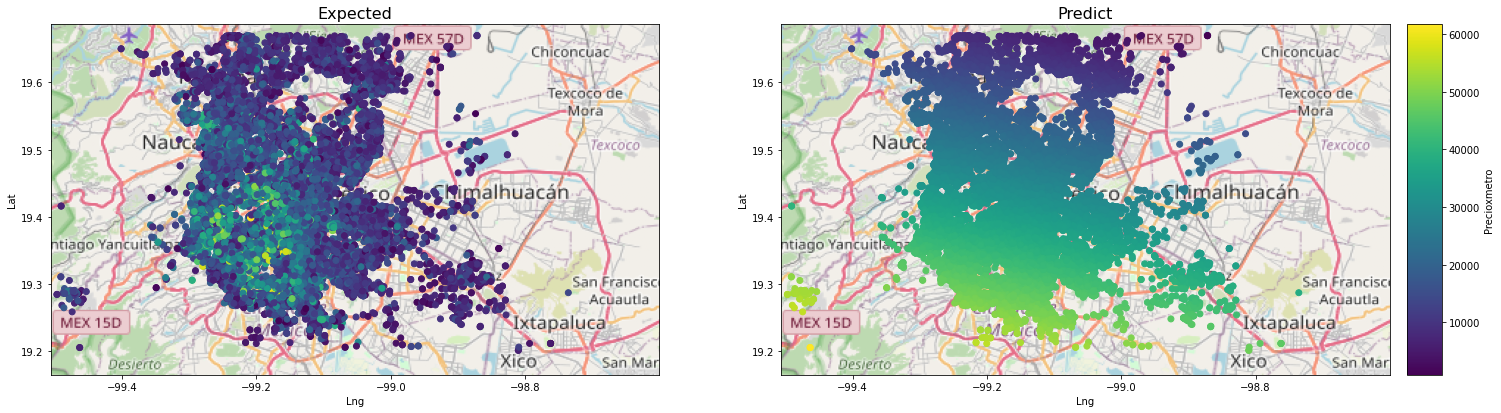

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(24,8))

lng = []
lat = []
c_pred = []
c_exp = []
for i,res in enumerate(res_prueba):
    lng += list(res["x"]["lng"])
    lat += list(res["x"]["lat"])
    c_pred += list(res["pred"])
    c_exp += list(res["expect"])

im1 = ax1.imshow(img_city, extent=[-99.5066,-98.6002,19.1646,19.6866], vmin = np.min(c_exp+c_pred), vmax = np.max(c_exp+c_pred))
ax1.scatter(lng,lat,c=c_exp)
ax1.set_title("Expected", fontsize=16)

ax2.imshow(img_city, extent=[-99.5066,-98.6002,19.1646,19.6866])
ax2.scatter(lng,lat,c=c_pred)
ax2.set_title("Predict", fontsize=16)

ax1.set_xlabel("Lng")
ax2.set_xlabel("Lng")

ax1.set_ylabel("Lat")
ax2.set_ylabel("Lat")


cax = fig.add_axes([ax2.get_position().x1+0.01,ax2.get_position().y0,0.02,ax2.get_position().height]) # Para que quede bien posicionado
cbar = fig.colorbar(im1, cax=cax)
cbar.ax.set_ylabel('Precioxmetro')

plt.savefig("precioxmetro/map_city_precios_predvsexp")
plt.show()

In [22]:
from sklearn.metrics import r2_score
df_res_ciudad = pd.DataFrame(columns=["lng","lat","y_true","y_pred"])
df_metricas_ciudad = pd.DataFrame(columns=["tipodepropiedad","RMSLE","R2_SCORE","RMSE","STD"])
for c in df_prueba.tipodepropiedad.unique():
    df_ciudad = df_prueba[df_prueba.tipodepropiedad == c]
    if df_ciudad.shape[0] < 50:
        continue
    try:
        res_ciudad, rmse_ciudad, rmsle_ciudad = linear_regression(df_ciudad,["lat","lng"], "precioxmetro", n_splits=4, shuffle=True)
        for r in res_ciudad: 
            df_res_ciudad = df_res_ciudad.append(pd.DataFrame(data={"lng":r["x"]["lng"],"lat":r["x"]["lat"],"y_true":r["expect"].reshape(len(r["expect"])),"y_pred":r["pred"]}), ignore_index=True)
        r2 = np.mean([r2_score(r["expect"],r["pred"]) for r in res_ciudad])
        df_metricas_ciudad = df_metricas_ciudad.append({"tipodepropiedad":c,"RMSLE":rmsle_ciudad,"R2_SCORE":r2,"RMSE":rmse_ciudad,"STD":df_ciudad.precioxmetro.std()}, ignore_index=True)
    except: 
        print(f"Could not resolve for {c}")
df_metricas_ciudad["RMSE/STD"] = df_metricas_ciudad["RMSE"]/df_metricas_ciudad["STD"]
df_metricas_ciudad

,tipodepropiedad,RMSLE,R2_SCORE,RMSE,STD,RMSE/STD
0,Casa en condominio,0.623314,0.117957,12573.789647,11998.377376,1.047958
1,Apartamento,0.540886,0.045925,11971.196641,11758.632174,1.018077
2,Casa,0.559348,0.088015,9226.814980,8868.550478,1.040397
3,Local Comercial,0.652422,0.123543,13560.114005,13099.641210,1.035152
4,Terreno,0.797254,0.022512,9083.136429,9163.462690,0.991234
5,Casa uso de suelo,0.554731,0.005144,12154.219996,11359.991973,1.069914
6,Edificio,0.546797,-0.025153,12418.968214,11873.214809,1.045965
7,Bodega comercial,0.447394,-0.080329,5392.293904,5592.436558,0.964212
8,Oficina comercial,0.514123,-0.002598,13238.331483,12590.007122,1.051495
9,Terreno comercial,0.713451,-0.020419,8625.165721,7982.042820,1.080571


In [26]:
from commons import rmsle 
rmsle(df_res_ciudad["y_true"],df_res_ciudad["y_pred"])

0.5239075925295963

In [25]:
from commons import rmse 
rmse(df_res_ciudad["y_true"],df_res_ciudad["y_pred"])

9980.993296277617

In [29]:
rmse(df_res_ciudad["y_true"],df_res_ciudad["y_pred"])/df_res_ciudad["y_true"].std()

0.9042392182845083

In [23]:
r2_score(df_res_ciudad["y_true"],df_res_ciudad["y_pred"])

0.182326400182363

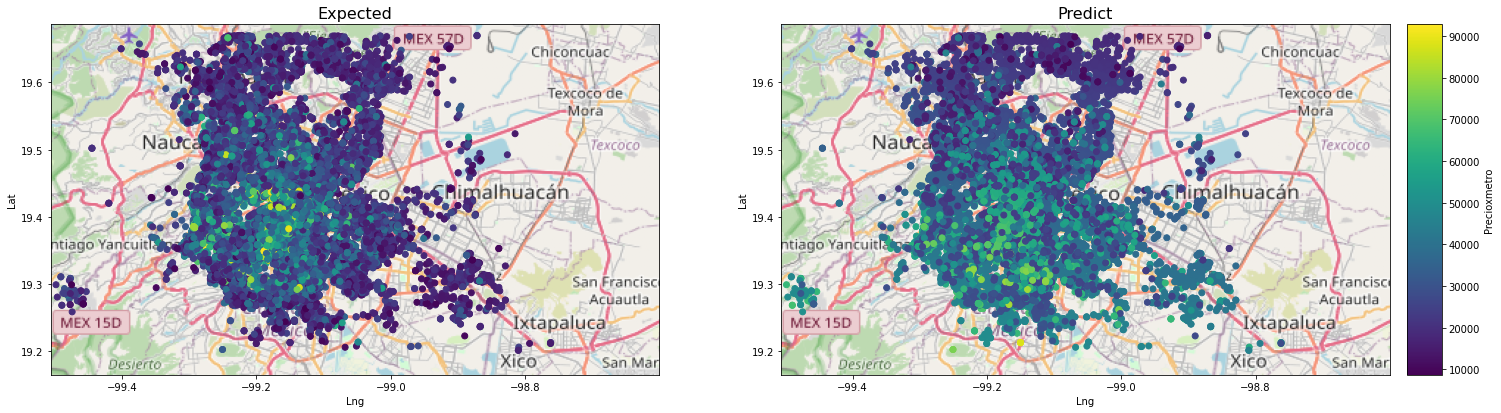

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(24,8))

lng = df_res_ciudad["lng"]
lat = df_res_ciudad["lat"]
c_pred = df_res_ciudad["y_pred"]
c_exp = df_res_ciudad["y_true"]

im1 = ax1.imshow(img_city, extent=[-99.5066,-98.6002,19.1646,19.6866], vmin = np.min(c_exp+c_pred), vmax = np.max(c_exp+c_pred))
ax1.scatter(lng,lat,c=c_exp)
ax1.set_title("Expected", fontsize=16)

ax2.imshow(img_city, extent=[-99.5066,-98.6002,19.1646,19.6866])
ax2.scatter(lng,lat,c=c_pred)
ax2.set_title("Predict", fontsize=16)

ax1.set_xlabel("Lng")
ax2.set_xlabel("Lng")

ax1.set_ylabel("Lat")
ax2.set_ylabel("Lat")

cax = fig.add_axes([ax2.get_position().x1+0.01,ax2.get_position().y0,0.02,ax2.get_position().height]) # Para que quede bien posicionado
cbar = fig.colorbar(im1, cax=cax)
cbar.ax.set_ylabel('Precioxmetro')

plt.savefig("precioxmetro/map_city_precios_predvsexp_seg")
plt.show()

In [31]:
df_clean = df[np.where((df["lng"] < -85.665) & (df["lng"] > -118.081) & (df["lat"] < 32.902) & (df["lat"] > 14.009), True ,False)]
df_clean = df_clean[np.where((df_clean["precioxmetro"] > 0) , True ,False)]

z_scores = np.abs((df_clean.precioxmetro - df_clean.precioxmetro.mean())/df_clean.precioxmetro.std(ddof=0))
filtered_entries = (z_scores < 3)
df_clean = df_clean[filtered_entries]

In [32]:
#https://www.openstreetmap.org/#map=5/21.207/-94.263
img_mex = plt.imread("map_mex_all.png")

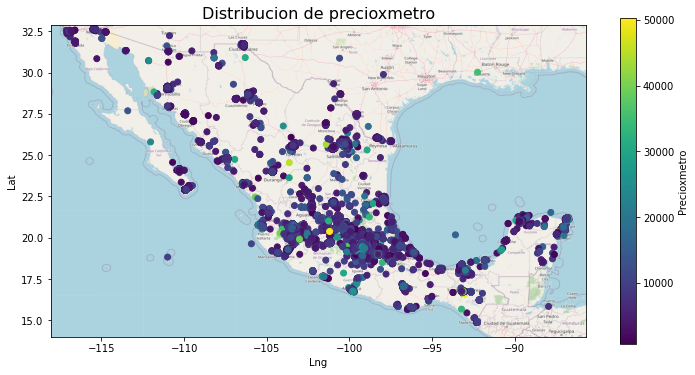

In [33]:
lng = df_clean['lng'].values
lat = df_clean['lat'].values
c = df_clean['precioxmetro'].values

plt.figure(figsize=(12,6))
plt.imshow(img_mex, extent=[-118.081,-85.665,14.009,32.902])
plt.scatter(lng,lat,c=c)
plt.savefig("mapprecios")
plt.title("Distribucion de precioxmetro", fontsize=16)
plt.ylabel("Lat")
plt.xlabel("Lng")

cbar = plt.colorbar()
cbar.ax.set_ylabel('Precioxmetro')
plt.savefig("precioxmetro/dist_precioxmetro_all")
plt.show()

In [34]:
res_clean,rmse_clean,rmsle_clean = linear_regression(df_clean,["lat","lng"], "precioxmetro", n_splits=4) 

/home/roni/Documents/metnum/metnum-tp3/notebooks/commons.py:10: RuntimeWarning: invalid value encountered in log
  return np.sqrt(((np.log(expec+1)-np.log(pred+1))**2).mean())


In [35]:
from sklearn.metrics import r2_score
r2_clean = 0
for r in res_clean:
    expec = r["expect"]
    pred = r["pred"]
    r2_clean+=r2_score(expec,pred)
r2_clean = np.mean(r2_clean)

In [36]:
rmse_clean,rmsle_clean,r2_clean,rmse_clean/df_clean.precioxmetro.std()

(9361.971349671889, nan, 0.31556400242974203, 1.0446865471029376)

/home/roni/.virtualenvs/metnumtp3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


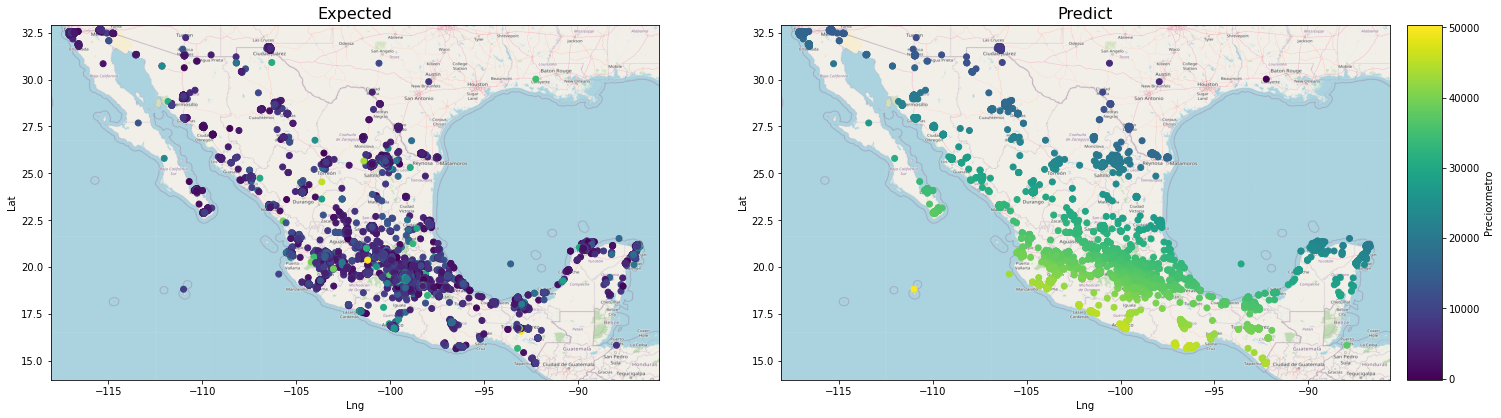

In [53]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(24,8))
lng = []
lat = []
c_pred = []
c_exp = []
for i,res in enumerate(res_clean):
    lng += list(res["x"]["lng"])
    lat += list(res["x"]["lat"])
    c_pred += list(res["pred"])
    c_exp += list(res["expect"])

im1 = ax1.imshow(img_mex, extent=[-118.081,-85.665,14.009,32.902], vmin = np.min(c_exp+c_pred), vmax = np.max(c_exp+c_pred))
ax1.scatter(lng,lat,c=c_exp)
ax1.set_title("Expected", fontsize=16)

ax2.imshow(img_mex, extent=[-118.081,-85.665,14.009,32.902])
ax2.scatter(lng,lat,c=c_pred)
ax2.set_title("Predict", fontsize=16)

ax1.set_xlabel("Lng")
ax2.set_xlabel("Lng")

ax1.set_ylabel("Lat")
ax2.set_ylabel("Lat")

cax = fig.add_axes([ax2.get_position().x1+0.01,ax2.get_position().y0,0.02,ax2.get_position().height]) # Para que quede bien posicionado
cbar = fig.colorbar(im1, cax=cax)
cbar.ax.set_ylabel('Precioxmetro')
plt.savefig("precioxmetro/map_all_precios_predvsexp")
plt.show()

In [83]:
np.mean([rmsle(res["expect"],res["pred"]) for res in res_clean][1:])

0.734876718500363

In [90]:
from sklearn.metrics import r2_score
df_res_provincia = pd.DataFrame(columns=["lng","lat","y_true","y_pred"])
df_metricas_provincia = pd.DataFrame(columns=["tipodepropiedad","RMSLE","R2_SCORE","RMSE","STD"])
for p in df_clean.tipodepropiedad.unique():
    df_provincia = df_clean[df_clean.tipodepropiedad == p]
    if df_provincia.shape[0] < 50:
        continue
    try:
        res_provincia, rmse_provincia, rmsle_provincia = linear_regression(df_provincia,["lat","lng"], "precioxmetro", n_splits=4, shuffle=True)
        for r in res_provincia: 
            df_res_provincia = df_res_provincia.append(pd.DataFrame(data={"lng":r["x"]["lng"],"lat":r["x"]["lat"],"y_true":r["expect"].reshape(len(r["expect"])),"y_pred":r["pred"]}), ignore_index=True)
        r2 = np.mean([r2_score(r["expect"],r["pred"]) for r in res_provincia])
        df_metricas_provincia = df_metricas_provincia.append({"tipodepropiedad":p,"RMSLE":rmsle_provincia,"R2_SCORE":r2,"RMSE":rmse_provincia,"STD":df_provincia.precioxmetro.std()}, ignore_index=True)
    except: 
        print(f"Could not resolve for {c}")
df_metricas_provincia["RMSE/STD"] = df_metricas_provincia["RMSE"]/df_metricas_provincia["STD"]
df_metricas_provincia

/home/roni/Documents/metnum/metnum-tp3/notebooks/commons.py:10: RuntimeWarning: invalid value encountered in log
  return np.sqrt(((np.log(expec+1)-np.log(pred+1))**2).mean())


,tipodepropiedad,RMSLE,R2_SCORE,RMSE,STD,RMSE/STD
0,Casa en condominio,0.566024,0.038476,9068.826640,8781.441660,1.032726
1,Casa,0.635321,0.079827,7353.359197,7008.512497,1.049204
2,Apartamento,0.562360,0.000444,10721.037384,10613.972961,1.010087
3,Local Comercial,0.785230,0.055502,11166.586760,10670.889450,1.046453
4,Terreno,0.858896,0.036484,6244.103537,6190.137011,1.008718
5,Oficina comercial,0.629383,0.086732,11233.736594,11262.637620,0.997434
6,Terreno comercial,0.868678,0.036658,5862.592293,6368.290098,0.920591
7,Casa uso de suelo,0.693457,0.090378,9813.574012,9207.611659,1.065811
8,Edificio,0.615614,0.058009,11044.963731,10441.823379,1.057762
9,Bodega comercial,0.614293,0.058698,5405.224631,5228.266689,1.033846


In [91]:
from commons import rmsle 
rmsle(df_res_provincia["y_true"],df_res_provincia["y_pred"])

/home/roni/.virtualenvs/metnumtp3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.5793308610968041

In [92]:
from commons import rmse 
rmse(df_res_provincia["y_true"],df_res_provincia["y_pred"])

7796.620572567667

In [93]:
rmse(df_res_provincia["y_true"],df_res_provincia["y_pred"])/df_res_provincia["y_true"].std()

0.8671434067613469

In [94]:
r2_score(df_res_provincia["y_true"],df_res_provincia["y_pred"])

0.24805392771542434

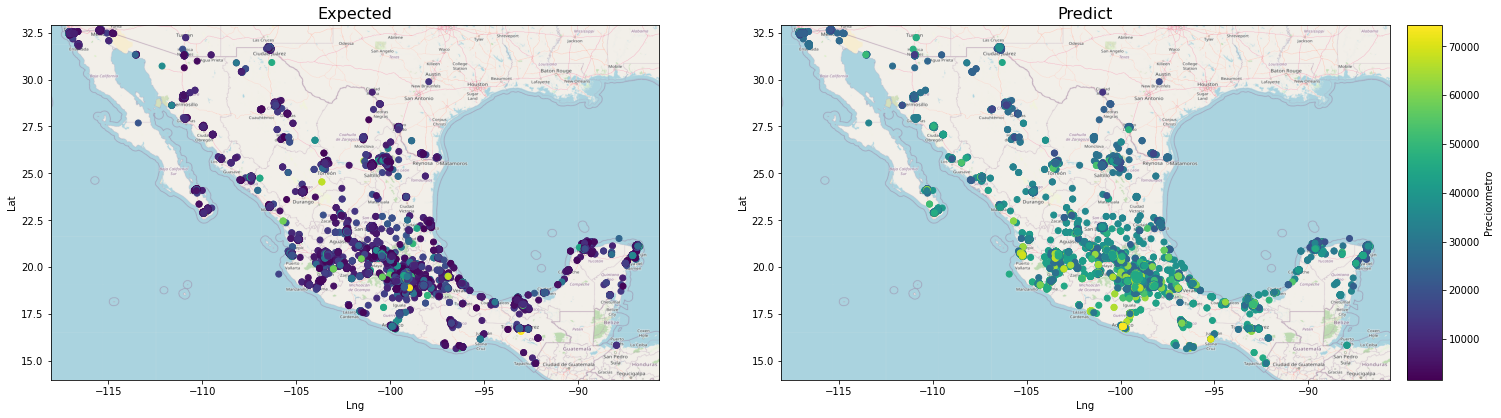

In [95]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(24,8))

lng = df_res_provincia["lng"]
lat = df_res_provincia["lat"]
c_pred = df_res_provincia["y_pred"]
c_exp = df_res_provincia["y_true"]

im1 = ax1.imshow(img_mex, extent=[-118.081,-85.665,14.009,32.902], vmin = np.min(c_exp+c_pred), vmax = np.max(c_exp+c_pred))
ax1.scatter(lng,lat,c=c_exp)
ax1.set_title("Expected", fontsize=16)


ax2.imshow(img_mex, extent=[-118.081,-85.665,14.009,32.902])
ax2.scatter(lng,lat,c=c_pred)
ax2.set_title("Predict", fontsize=16)

ax1.set_xlabel("Lng")
ax2.set_xlabel("Lng")

ax1.set_ylabel("Lat")
ax2.set_ylabel("Lat")

cax = fig.add_axes([ax2.get_position().x1+0.01,ax2.get_position().y0,0.02,ax2.get_position().height]) # Para que quede bien posicionado
cbar = fig.colorbar(im1, cax=cax)
cbar.ax.set_ylabel('Precioxmetro')

plt.savefig("precioxmetro/map_all_precios_predvsexp_seg")
plt.show()